# Микродиахроническое исследование русских приставок методами дистрибутивной семантики
## Автор: Елизавета Клыкова, БКЛ181
### Часть 8: выравнивание моделей + подсчет изменений
1. Взять код Orthogonal Procrustes alignment у Hamilton et al. (2016)
2. Выровнять модели: советский с досоветским, постсоветский с советским
3. Повторить для моделей с приклеенными частями речи
4. Рассчитать расстояние Манхэттэна для релевантных периодов (там, где это возможно)
5. Отранжировать глаголы внутри приставки и приставки относительно друг друга

\+ оценка на материале [RuShiftEval](https://github.com/akutuzov/rushifteval_public) (credits to Даша Рыжова за эту идею)

#### Импорт модулей

In [1]:
# %load_ext pycodestyle_magic
# %pycodestyle_on

In [2]:
import gensim
import numpy as np
import pandas as pd
from tqdm.auto import tqdm
from statistics import mean
from scipy.spatial.distance import cityblock
import scipy.cluster.hierarchy as hcluster
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

#### Загрузка моделей

In [3]:
def load_word2vec_model(file_with_model):
    model = gensim.models.KeyedVectors.load_word2vec_format(file_with_model,
                                                            binary=True)
    print('Размер словаря:', len(model.wv.vocab))
    return model

1. Базовые (леммы без пунктуации)

In [4]:
presov_model = load_word2vec_model('word2vec/word2vec_presov_lemmas.bin')

Размер словаря: 127656


In [5]:
sov_model = load_word2vec_model('word2vec/word2vec_sov_lemmas.bin')

Размер словаря: 151890


In [6]:
postsov_model = load_word2vec_model('word2vec/word2vec_postsov_lemmas.bin')

Размер словаря: 149617


2. Леммы + части речи (без пунктуации)

In [7]:
presov_pos_model = load_word2vec_model('word2vec/word2vec_presov_lemmas_pos.bin')

Размер словаря: 123804


In [8]:
sov_pos_model = load_word2vec_model('word2vec/word2vec_sov_lemmas_pos.bin')

Размер словаря: 147146


In [9]:
postsov_pos_model = load_word2vec_model('word2vec/word2vec_postsov_lemmas_pos.bin')

Размер словаря: 144650


#### Выравнивание: Procrustes alignment, (Hamilton et al. 2016)
Код взят [отсюда](https://gist.github.com/zhicongchen/9e23d5c3f1e5b1293b16133485cd17d8).

In [10]:
def intersection_align_gensim(m1, m2, words=None):
    """
    Intersect two gensim word2vec models, m1 and m2.
    Only the shared vocabulary between them is kept.
    If 'words' is set (as list or set), then the vocabulary is intersected with this list as well.
    Indices are re-organized from 0..N in order of descending frequency (=sum of counts from both m1 and m2).
    These indices correspond to the new syn0 and syn0norm objects in both gensim models:
        -- so that Row 0 of m1.syn0 will be for the same word as Row 0 of m2.syn0
        -- you can find the index of any word on the .index2word list: model.index2word.index(word) => 2
    The .vocab dictionary is also updated for each model, preserving the count but updating the index.
    """

    # Get the vocab for each model
    vocab_m1 = set(m1.wv.vocab.keys())
    vocab_m2 = set(m2.wv.vocab.keys())

    # Find the common vocabulary
    common_vocab = vocab_m1 & vocab_m2
    if words:
        common_vocab &= set(words)

    # If no alignment necessary because vocab is identical...
    if not vocab_m1-common_vocab and not vocab_m2-common_vocab:
        return (m1, m2)

    # Otherwise sort by frequency (summed for both)
    common_vocab = list(common_vocab)
    common_vocab.sort(key=lambda w: m1.wv.vocab[w].count + m2.wv.vocab[w].count, reverse=True)

    # Then for each model...
    for m in [m1, m2]:
        # Replace old syn0norm array with new one (with common vocab)
        indices = [m.wv.vocab[w].index for w in common_vocab]
        old_arr = m.wv.syn0norm
        new_arr = np.array([old_arr[index] for index in indices])
        m.wv.syn0norm = m.wv.syn0 = new_arr

        # Replace old vocab dictionary with new one (with common vocab)
        # and old index2word with new one
        m.wv.index2word = common_vocab
        old_vocab = m.wv.vocab
        new_vocab = {}
        for new_index, word in enumerate(common_vocab):
            old_vocab_obj = old_vocab[word]
            new_vocab[word] = gensim.models.word2vec.Vocab(index=new_index, count=old_vocab_obj.count)
        m.wv.vocab = new_vocab

    return (m1, m2)

In [11]:
def smart_procrustes_align_gensim(base_embed, other_embed, words=None):
    """
    Procrustes align two gensim word2vec models (to allow for comparison between same word across models).
    Code ported from HistWords <https://github.com/williamleif/histwords> by William Hamilton <wleif@stanford.edu>.
        (With help from William. Thank you!)

    First, intersect the vocabularies (see `intersection_align_gensim` documentation).
    Then do the alignment on the other_embed model.
    Replace the other_embed model's syn0 and syn0norm numpy matrices with the aligned version.
    Return other_embed.

    If `words` is set, intersect the two models' vocabulary with the vocabulary in words (see `intersection_align_gensim` documentation).
    """

    # patch by Richard So [https://twitter.com/richardjeanso] (thanks!) to update this code for new version of gensim
    base_embed.init_sims()
    other_embed.init_sims()

    # make sure vocabulary and indices are aligned
    in_base_embed, in_other_embed = intersection_align_gensim(base_embed, other_embed, words=words)

    # get the embedding matrices
    base_vecs = in_base_embed.wv.syn0norm
    other_vecs = in_other_embed.wv.syn0norm

    # just a matrix dot product with numpy
    m = other_vecs.T.dot(base_vecs)
    # SVD method from numpy
    u, _, v = np.linalg.svd(m)
    # another matrix operation
    ortho = u.dot(v)
    # Replace original array with modified one
    # i.e. multiplying the embedding matrix (syn0norm)by "ortho"
    other_embed.wv.syn0norm = other_embed.wv.syn0 = (other_embed.wv.syn0norm).dot(ortho)

    return other_embed

Выравниваем базовые модели:

In [12]:
sov_to_presov = smart_procrustes_align_gensim(presov_model, sov_model)

In [13]:
postsov_to_sov = smart_procrustes_align_gensim(sov_model, postsov_model)

Выравниваем модели с частями речи:

In [14]:
sov_to_presov_pos = smart_procrustes_align_gensim(presov_pos_model, sov_pos_model)

In [15]:
postsov_to_sov_pos = smart_procrustes_align_gensim(sov_pos_model, postsov_pos_model)

#### Получение векторов глаголов

In [16]:
pref_df = pd.read_csv('prefixes_and_lemmas.tsv', sep='\t')
pref_df

,prefix,lemma,freq,freq_0,freq_1,freq_2
0,бе[зс],бездействовать,541,155,255,131
1,бе[зс],бездельничать,308,41,169,98
2,бе[зс],безмолвствовать,726,361,191,174
3,бе[зс],безобразить,149,99,43,7
4,бе[зс],безобразничать,306,110,136,60
...,...,...,...,...,...,...
8440,у,ущемляться,62,8,16,38
8441,у,ущипывать,510,147,222,141
8442,у,уязвлять,1305,606,411,288
8443,у,уяснять,1803,677,740,386


In [17]:
# list of dicts
pref_dict = pref_df.to_dict(orient='records')

Нам нужны:
- вектор досоветского периода
- вектор советского периода, выровненный с досоветским
- вектор постсоветского периода, выровненный с советским (и досоветским по определению)
- было проверено, что при выравнивании постсоветского с досоветским получаются те же векторы
- все то же самое для моделей с частями речи

In [18]:
for verb in pref_dict:
    # базовые модели
    lemma = verb['lemma']
    verb['v_presov'] = presov_model[lemma] if lemma in presov_model else None
    verb['v_sov'] = sov_to_presov[lemma] if lemma in sov_to_presov else None
    verb['v_postsov'] = postsov_to_sov[lemma] if lemma in postsov_to_sov else None
    # модели с частями речи
    lemma = verb['lemma'] + '_' + 'V'
    verb['vpos_presov'] = presov_pos_model[lemma] if lemma in presov_pos_model else None
    verb['vpos_sov'] = sov_to_presov_pos[lemma] if lemma in sov_to_presov_pos else None
    verb['vpos_postsov'] = postsov_to_sov_pos[lemma] if lemma in postsov_to_sov_pos else None

#### Выявление изменений с помощью расстояния Манхеттена
Расстояние Манхэттэна: Σ|Ai – Bi|. Для каждой леммы считаем расстояние между советским и досоветским, постсоветским и советским, постсоветским и досоветским (+ то же самое для модели с частями речи). Если в каком-то периоде нет нужного значения (слово не встретилось в модели), оставляем None.

In [19]:
for verb in pref_dict:

    # базовые модели
    if verb['v_presov'] is not None and verb['v_sov'] is not None:
        verb['d_pre_to_sov'] = cityblock(verb['v_presov'], verb['v_sov'])
    else:
        verb['d_pre_to_sov'] = None
    if verb['v_sov'] is not None and verb['v_postsov'] is not None:
        verb['d_sov_to_post'] = cityblock(verb['v_sov'], verb['v_postsov'])
    else:
        verb['d_sov_to_post'] = None
    if verb['v_presov'] is not None and verb['v_postsov'] is not None:
        verb['d_pre_to_post'] = cityblock(verb['v_presov'], verb['v_postsov'])
    else:
        verb['d_pre_to_post'] = None

    # модели с частями речи
    if verb['vpos_presov'] is not None and verb['vpos_sov'] is not None:
        verb['dpos_pre_to_sov'] = cityblock(verb['vpos_presov'], verb['vpos_sov'])
    else:
        verb['dpos_pre_to_sov'] = None
    if verb['vpos_sov'] is not None and verb['vpos_postsov'] is not None:
        verb['dpos_sov_to_post'] = cityblock(verb['vpos_sov'], verb['vpos_postsov'])
    else:
        verb['dpos_sov_to_post'] = None
    if verb['vpos_presov'] is not None and verb['vpos_postsov'] is not None:
        verb['dpos_pre_to_post'] = cityblock(verb['vpos_presov'], verb['vpos_postsov'])
    else:
        verb['dpos_pre_to_post'] = None

Выделим глаголы, которые встретились во всех периодах, и отранжируем их по степени изменения (внутри каждой приставки свой список). Пока не будем смотреть на глаголы, которых в том или ином периоде не оказалось (но посмотрим на них позже, поскольку они также могут дать ценную информацию о сочетаемости и т.д.).

In [20]:
prefixes = sorted(list(set([verb['prefix'] for verb in pref_dict])))

In [21]:
w2v_lemma_dict = {}
w2v_pos_dict = {}

for prefix in prefixes:
    w2v_lemma_dict[prefix] = []
    w2v_pos_dict[prefix] = []

Для сравнимости результатов берем всегда одни и те же глаголы:

In [22]:
for verb in pref_dict:
    check_vectors = [verb['v_presov'], verb['v_sov'], verb['v_postsov'],
                     verb['vpos_presov'], verb['vpos_sov'], verb['vpos_postsov']]
    if not any(elem is None for elem in check_vectors):
        w2v_lemma_dict[verb['prefix']].append(verb)
        w2v_pos_dict[verb['prefix']].append(verb)

#### Считаем для базовых моделей

In [23]:
for prefix in w2v_lemma_dict:
    verbs = w2v_lemma_dict[prefix]
    pre_to_sov = [(verb['lemma'], verb['d_pre_to_sov'])
                  for verb in sorted(verbs,
                                     key=lambda x: x['d_pre_to_sov'],
                                     reverse=True)]
    sov_to_post = [(verb['lemma'], verb['d_sov_to_post'])
                   for verb in sorted(verbs,
                                      key=lambda x: x['d_sov_to_post'],
                                      reverse=True)]
    pre_to_post = [(verb['lemma'], verb['d_pre_to_post'])
                   for verb in sorted(verbs,
                                      key=lambda x: x['d_pre_to_post'],
                                      reverse=True)]
    w2v_lemma_dict[prefix] = {'pre_to_sov_mean': mean([v[1] for v in pre_to_sov]),
                              'sov_to_post_mean': mean([v[1] for v in sov_to_post]),
                              'pre_to_post_mean': mean([v[1] for v in pre_to_post]),
                              'pre_to_sov_ranged': pre_to_sov,
                              'sov_to_post_ranged': sov_to_post,
                              'pre_to_post_ranged': pre_to_post}

In [24]:
w2v_lemma_dict['полу']['sov_to_post_mean']

14.401225

#### Ранжирование приставок по средней степени изменения в период

In [25]:
prefs_pre_to_sov_ranged = [(pref,
                            len(w2v_lemma_dict[pref]['pre_to_sov_ranged']),
                            w2v_lemma_dict[pref]['pre_to_sov_mean'])
                           for pref in sorted(w2v_lemma_dict,
                                              key=lambda x: w2v_lemma_dict[x]['pre_to_sov_mean'],
                                              reverse=True)]

In [26]:
prefs_pre_to_sov_ranged

[('недо', 17, 14.99659),
 ('обе[зс]', 27, 14.573118),
 ('полу', 17, 14.42894),
 ('над', 17, 13.81196),
 ('бе[зс]', 11, 13.70461),
 ('пере', 356, 13.596336),
 ('на', 523, 13.302644),
 ('про', 483, 13.251364),
 ('за', 937, 13.179125),
 ('ра[зс]', 621, 13.144019),
 ('и[зс]', 275, 13.09914),
 ('о', 815, 13.095943),
 ('ни[зс]', 10, 13.051192),
 ('от', 393, 13.008765),
 ('под', 265, 12.995167),
 ('во?', 137, 12.90297),
 ('по', 1007, 12.821486),
 ('вы', 444, 12.775991),
 ('во[зс]', 122, 12.722906),
 ('в[зс]', 150, 12.7190695),
 ('до', 153, 12.662589),
 ('с', 652, 12.624213),
 ('при', 411, 12.370303),
 ('пред', 58, 12.259981),
 ('у', 465, 12.234318),
 ('пре', 68, 11.745227)]

In [27]:
prefs_sov_to_post_ranged = [(pref,
                             len(w2v_lemma_dict[pref]['sov_to_post_ranged']),
                             w2v_lemma_dict[pref]['sov_to_post_mean'])
                            for pref in sorted(w2v_lemma_dict,
                                               key=lambda x: w2v_lemma_dict[x]['sov_to_post_mean'],
                                               reverse=True)]

In [28]:
prefs_pre_to_post_ranged = [(pref,
                             len(w2v_lemma_dict[pref]['pre_to_post_ranged']),
                             w2v_lemma_dict[pref]['pre_to_post_mean'])
                            for pref in sorted(w2v_lemma_dict,
                                               key=lambda x: w2v_lemma_dict[x]['pre_to_post_mean'],
                                               reverse=True)]

#### Повторяем все, что выше, для моделей с частями речи

In [29]:
for prefix in w2v_pos_dict:
    verbs = w2v_pos_dict[prefix]
    pre_to_sov = [(verb['lemma'], verb['dpos_pre_to_sov'])
                  for verb in sorted(verbs,
                                     key=lambda x: x['dpos_pre_to_sov'],
                                     reverse=True)]
    sov_to_post = [(verb['lemma'], verb['dpos_sov_to_post'])
                   for verb in sorted(verbs,
                                      key=lambda x: x['dpos_sov_to_post'],
                                      reverse=True)]
    pre_to_post = [(verb['lemma'], verb['dpos_pre_to_post'])
                   for verb in sorted(verbs,
                                      key=lambda x: x['dpos_pre_to_post'],
                                      reverse=True)]
    w2v_pos_dict[prefix] = {'pre_to_sov_mean': mean([v[1] for v in pre_to_sov]),
                            'sov_to_post_mean': mean([v[1] for v in sov_to_post]),
                            'pre_to_post_mean': mean([v[1] for v in pre_to_post]),
                            'pre_to_sov_ranged': pre_to_sov,
                            'sov_to_post_ranged': sov_to_post,
                            'pre_to_post_ranged': pre_to_post}

In [30]:
prefs_pre_to_sov_pos_ranged = [(pref,
                                len(w2v_pos_dict[pref]['pre_to_sov_ranged']),
                                w2v_pos_dict[pref]['pre_to_sov_mean'])
                               for pref in sorted(w2v_pos_dict,
                                                  key=lambda x: w2v_pos_dict[x]['pre_to_sov_mean'],
                                                  reverse=True)]

In [31]:
prefs_sov_to_post_pos_ranged = [(pref,
                                 len(w2v_pos_dict[pref]['sov_to_post_ranged']),
                                 w2v_pos_dict[pref]['sov_to_post_mean'])
                                for pref in sorted(w2v_pos_dict,
                                                   key=lambda x: w2v_pos_dict[x]['sov_to_post_mean'],
                                                   reverse=True)]

In [32]:
prefs_pre_to_post_pos_ranged = [(pref,
                                 len(w2v_pos_dict[pref]['pre_to_post_ranged']),
                                 w2v_pos_dict[pref]['pre_to_post_mean'])
                                for pref in sorted(w2v_pos_dict,
                                                   key=lambda x: w2v_pos_dict[x]['pre_to_post_mean'],
                                                   reverse=True)]

#### Собираем в датафрейм для наглядности

In [33]:
pref_ranged_df = pd.DataFrame(
    {'w2vlem_pre_to_sov': prefs_pre_to_sov_ranged,
     'w2vlem_sov_to_post': prefs_sov_to_post_ranged,
     'w2vlem_pre_to_post': prefs_pre_to_post_ranged,
     'w2vpos_pre_to_sov': prefs_pre_to_sov_pos_ranged,
     'w2vpos_sov_to_post': prefs_sov_to_post_pos_ranged,
     'w2vpos_pre_to_post': prefs_pre_to_post_pos_ranged,
     })

In [34]:
pref_ranged_df

,w2vlem_pre_to_sov,w2vlem_sov_to_post,w2vlem_pre_to_post,w2vpos_pre_to_sov,w2vpos_sov_to_post,w2vpos_pre_to_post
0,"(недо, 17, 14.99659)","(недо, 17, 14.426576)","(недо, 17, 15.715141)","(недо, 17, 14.97861)","(полу, 17, 14.358989)","(недо, 17, 15.99652)"
1,"(обе[зс], 27, 14.573118)","(полу, 17, 14.401225)","(обе[зс], 27, 15.39006)","(обе[зс], 27, 14.637605)","(обе[зс], 27, 14.341099)","(обе[зс], 27, 15.439433)"
2,"(полу, 17, 14.42894)","(обе[зс], 27, 14.298121)","(полу, 17, 14.960836)","(полу, 17, 14.338059)","(недо, 17, 14.29634)","(полу, 17, 14.99648)"
3,"(над, 17, 13.81196)","(бе[зс], 11, 14.03681)","(бе[зс], 11, 14.72792)","(бе[зс], 11, 13.856313)","(бе[зс], 11, 14.005821)","(бе[зс], 11, 14.944925)"
4,"(бе[зс], 11, 13.70461)","(над, 17, 13.573008)","(пере, 356, 14.58536)","(над, 17, 13.847142)","(над, 17, 13.587695)","(пере, 356, 14.532836)"
5,"(пере, 356, 13.596336)","(ни[зс], 10, 13.5455265)","(над, 17, 14.582028)","(пере, 356, 13.570927)","(ни[зс], 10, 13.301887)","(над, 17, 14.476915)"
6,"(на, 523, 13.302644)","(пере, 356, 13.122657)","(на, 523, 14.401475)","(на, 523, 13.303542)","(пере, 356, 13.099909)","(на, 523, 14.34752)"
7,"(про, 483, 13.251364)","(на, 523, 13.046146)","(за, 937, 14.301837)","(про, 483, 13.19236)","(на, 523, 13.035655)","(за, 937, 14.264283)"
8,"(за, 937, 13.179125)","(и[зс], 275, 12.937429)","(и[зс], 275, 14.265233)","(за, 937, 13.179033)","(и[зс], 275, 12.935182)","(и[зс], 275, 14.235817)"
9,"(ра[зс], 621, 13.144019)","(за, 937, 12.89423)","(про, 483, 14.202373)","(ра[зс], 621, 13.127561)","(за, 937, 12.866041)","(о, 815, 14.175009)"


#### Кластеризация
Сначала для последнего периода, потому что для него чище данные. Пробуем иерархическую.

In [35]:
# np.array векторов всех глаголов с одной приставкой в постсоветском периоде (в модели без частей речи)
w2v_lem_for_clust = {pref: [] for pref in prefixes}
w2v_pos_for_clust = {pref: [] for pref in prefixes}

for verb in pref_dict:
    if verb['v_presov'] is not None and verb['v_sov'] is not None and verb['v_postsov'] is not None:
        w2v_lem_for_clust[verb['prefix']].append((verb['lemma'], verb['v_postsov']))
    if verb['vpos_presov'] is not None and verb['vpos_sov'] is not None and verb['vpos_postsov'] is not None:
        w2v_pos_for_clust[verb['prefix']].append((verb['lemma'], verb['vpos_postsov']))

In [36]:
vlem_array = np.array([v[1] for v in w2v_lem_for_clust['при']])

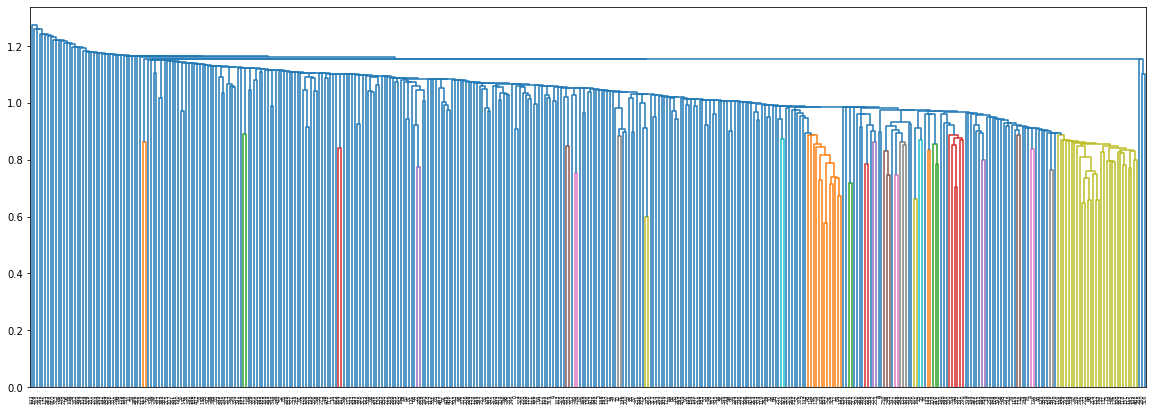

In [37]:
cl = hcluster.linkage(vlem_array)
plt.figure(figsize=(20, 7))
dn = hcluster.dendrogram(cl)
plt.show()

In [50]:
clusters = hcluster.fcluster(cl, 1.147)
len(set(clusters))

240

In [39]:
clusters_dict = {}
vlem_labels = [v[0] for v in w2v_lem_for_clust['при']]

for i, cluster in enumerate(clusters):
    verb = vlem_labels[i]
    vector = vlem_array[i]
    labeled_vector = (verb, vector)
    if cluster not in clusters_dict:
        clusters_dict[cluster] = [labeled_vector]
    else:
        clusters_dict[cluster].append(labeled_vector)

In [40]:
for cluster in clusters_dict:
    elements = [el[0] for el in clusters_dict[cluster]]
    if len(elements) > 2:
        print(cluster)
        print(elements)

23
['прибавлять', 'прибавляться', 'примешать', 'примешивать', 'примешиваться', 'приплетать', 'притекать']
45
['прибегать', 'прибывать', 'привозить', 'приволакивать', 'приглашать', 'приглашаться', 'пригонять', 'приезжать', 'прийти', 'прикатить', 'прилетать', 'примчаться', 'приносить', 'приплывать', 'прискакивать', 'присылать', 'притаскивать', 'прихватывать', 'приходить']
32
['прививать', 'прививаться', 'приживаться']
19
['привидеться', 'пригрезиться', 'придуматься', 'придумывать', 'придумываться', 'приключаться', 'примерещиться', 'припоминать', 'припоминаться', 'присниться']
6
['привирать', 'приукрашать', 'приукрашивать', 'прихвастывать']
52
['привлекать', 'привлекаться', 'применять', 'применяться']
31
['привносить', 'придавать', 'придаваться', 'приобретать', 'приобретаться']
51
['привставать', 'примащиваться', 'приподниматься', 'приподымать', 'присаживаться', 'приседать', 'пристраивать', 'пристраиваться', 'притулиться', 'притыкать', 'притыкаться']
56
['привыкать', 'прилаживаться', 'при

Просматривается определенная логика, связанная с семантикой корней.